# Simulating black hole evaporation with quantum computer
In [1], quantum simulation of Page curve in quantum gravity is simplified and mapped to quantum circuit model.
In this notebook, we demonstrate how qsub [2] can be used to implement their construction to simulate black hole evaporation on a quantum computer.
We demonstrate both the ideal and noisy simulations where early-FTQC articheture is used.

## 0 · Physical background: the Page curve and black‑hole evaporation

A black hole that evaporates by emitting Hawking radiation starts in a *pure* quantum state.
If we partition the full Hilbert space into the **radiation** subsystem $R(t)$ that has escaped up to time $t$
and the **remaining black‑hole** subsystem $B(t)$, then unitarity demands
$$S_{	ext{vN}}\bigl(\rho_{RB}(t)\bigr)=0,$$
yet each individual subsystem generically becomes *mixed*.
To map this idea to quantum circuits, one interprets the quantum circuit as the figure below [1]

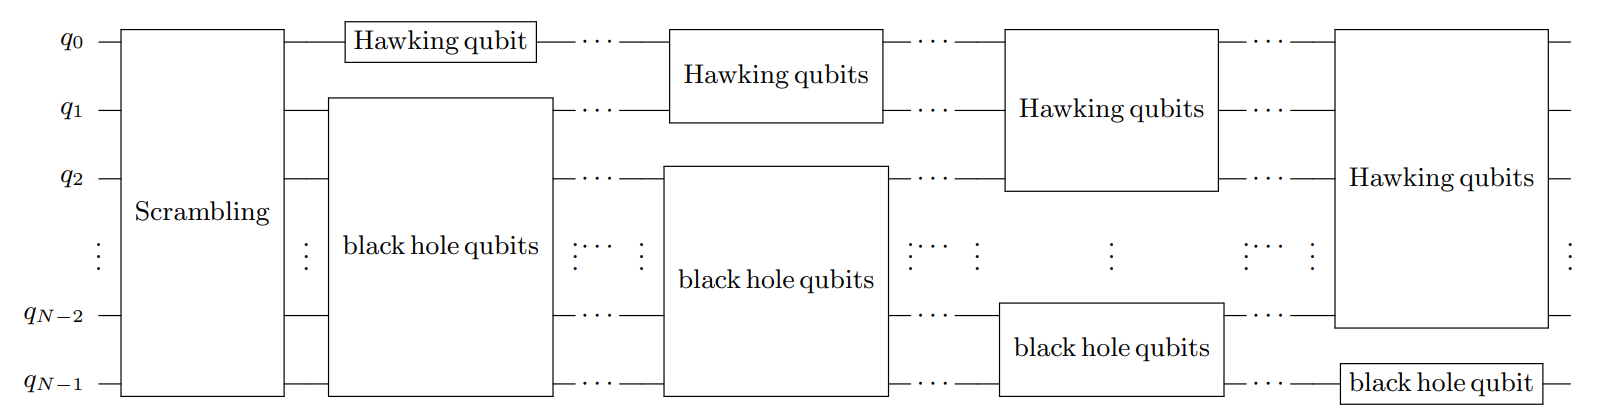

which is called the qubit transport model.
In this case, unitarity is presereved and we can perform measurement and calculate entropy at each time step.
Note that this is the simplest model, and in practice, there will be backreaction from radiation to black hole, which is ignored in this model.

According to Page [3], the entropy should be constrainted by unitrary and form the so-called **Page curve**.
The **Page curve** is the time‑dependence of the entanglement entropy
$$S_R(t)=S_B(t)= -\operatorname{Tr}\bigl[\rho_R(t)\log\rho_R(t)\bigr]$$
as the evaporation progresses.

Page’s theorem [3] predicts that for a *random* pure state on
$\mathcal H_R\otimes\mathcal H_B$ with dimensions $d_R\le d_B$,
the *average* entropy of the smaller subsystem is

$$
\langle S_R \rangle
\;=\; \sum_{k=d_B+1}^{d_Rd_B} \frac{1}{k}
-\;\frac{d_R-1}{2d_B}
\;\approx\; \log d_R -\frac{d_R}{2d_B}.
$$

Applied to black holes, the entropy of the radiation increases linearly until roughly half the qubits have been emitted, after which it decreases, yielding the characteristic ``Page curve'' shape shown below.

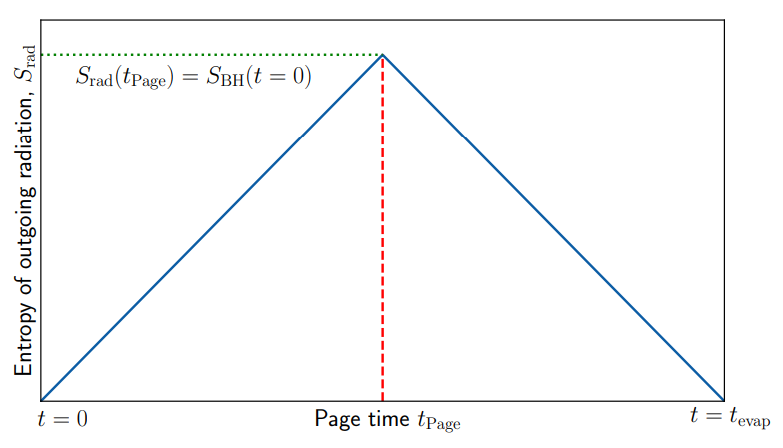

---


### Random‑unitary circuits as a toy model

Following [1], we first model the scrambling dynamics of a black hole.
Starting from initialized qubits, we need to make them into maximally mixed state, hence approximating the classical state of a black hole.
To do this, we use **random‑unitary circuit** (RUC) to build a brickwall of random 2-qubit gates.
That is, nearest‑neighbour two‑qubit SU(4) gates chosen independently at every time layer.
After each layer, one qubit is traced out (``radiated'').
The **swap test** then lets us measure the second‑Rényi entropy
$$S_2(\rho)= -\log_2\,\operatorname{Tr}[\rho^2],$$
which approximates the von Neumann entropy for large Hilbert spaces.

In the sections below we first construct the RUC and the swap‑test
circuit, then sample over many random instances.
Finally, we compare the numerical average $\langle S_2\rangle$ with the analytic Page‑curve expectation above.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(1217)  # reproducibility


## 1 · Define a random two‑qubit unitary `RandomSU4`  

We define an OpSub function that applies three random Pauli‑rotation layers, which together form a random element of SU(4).

In [ ]:
from quri_parts.qsub.lib import std
from quri_parts.qsub.sub import SubBuilder
from quri_parts.qsub.opsub import ParamOpSubDef, param_opsub

class _RandomSU4(ParamOpSubDef[float, float, float]):
    """One SU(4) block parameterised by three Euler angles."""
    name = "RandomSU4"
    qubit_count = 2

    def sub(self, builder: SubBuilder, a: float, b: float, c: float) -> None:
        q0, q1 = builder.qubits
        for pauli_pair, theta in zip([(1,1), (2,2), (3,3)], (a, b, c)):
            builder.add_op(std.PauliRotation(pauli_pair, theta), (q0, q1))

# Factory function
RandomSU4, _ = param_opsub(_RandomSU4)


In terms of quantum circuit, it looks like this:

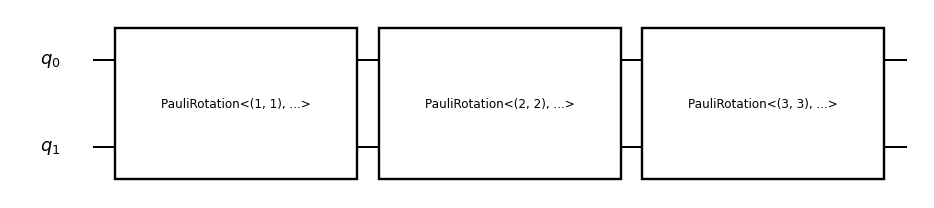

In [ ]:
from quri_parts.qsub.visualize import draw_sub

random_su4_op = RandomSU4(*(2 * np.pi * np.random.rand(3)))
draw_sub(random_su4_op)

After compilation, the block is shown as follows

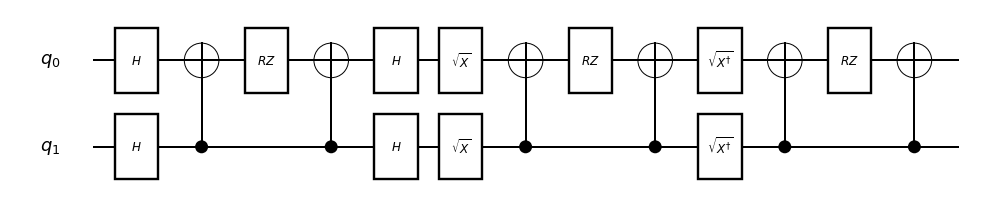

In [ ]:
from quri_parts.qsub.resolve import resolve_sub
from quri_parts.qsub.compile import compile_sub
from quri_parts.qsub.primitive import AllBasicSet
from quri_parts.qsub.evaluate import Evaluator
from quri_parts.qsub.eval import QURIPartsEvaluatorHooks
from quri_parts.qulacs.circuit import convert_circuit
from qulacsvis import circuit_drawer

qc_demo = Evaluator(QURIPartsEvaluatorHooks()).run(
    compile_sub(resolve_sub(random_su4_op), AllBasicSet)
)

circuit_drawer(convert_circuit(qc_demo), output_method="mpl")

## 2 · Build a random‑unitary circuit (`RUC`)  

Next, we build the RUC function by stacking the SU(4) gates to form a brickwall as mentioned in the beginning.

In [ ]:
class _RUC(ParamOpSubDef[int, int]):
    """Nearest‑neighbour random‑unitary circuit."""
    name = "RUC"

    def qubit_count_fn(self, n_qubits: int, _layers: int) -> int:
        return n_qubits

    def sub(self, builder: SubBuilder, n_qubits: int, n_layers: int) -> None:
        qs = builder.qubits
        for layer in range(n_layers):
            start = layer % 2
            for i in range(start, n_qubits - 1, 2):
                angles = 2 * np.pi * np.random.random(3)
                builder.add_op(RandomSU4(*angles), (qs[i], qs[i+1]))

RUC, _ = param_opsub(_RUC)


Below is the visualization of the RUC circuit for 4 qubits with 2 layers.

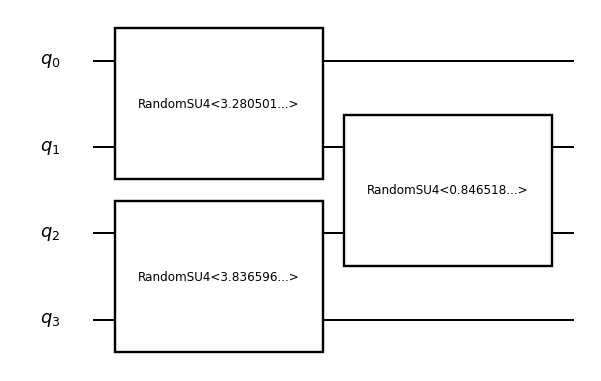

In [ ]:
from quri_parts.qsub.visualize import draw_sub
from quri_parts.qsub.resolve import resolve_sub

# Symbolic (uncompiled) RUC on 4 qubits, 2 layers
ruc_demo_sym = resolve_sub(RUC(4, 2))
draw_sub(ruc_demo_sym)

## 3 · Swap test  

An ancilla qubit controls SWAPs between two scrambled copies of the system.  
Measuring the ancilla gives access to the **2‑Rényi entropy** of the subsystem selected by the SWAPs.
The circuit of swap test is illustrated below, and its implementation of the circuit as well.

In [ ]:
class _SwapTest(ParamOpSubDef[int, int, int]):
    """Swap Test to estimate purity / Rényi‑2."""
    name = "SwapTest"

    def qubit_count_fn(self, n_system: int, *_):       # ancilla + 2 copies
        return 2 * n_system + 1

    def sub(self, builder: SubBuilder, n_system: int, n_layers: int, n_rad: int) -> None:
        qs = builder.qubits
        ancilla = qs[0]
        sysA = qs[1 : n_system + 1]
        sysB = qs[n_system + 1 : 2 * n_system + 1]

        builder.add_op(std.H, (ancilla,))
        builder.add_op(RUC(n_system, n_layers), sysA)
        builder.add_op(RUC(n_system, n_layers), sysB)

        for i in range(n_rad):
            builder.add_op(std.Controlled(std.SWAP), (ancilla, sysA[i], sysB[i]))

        builder.add_op(std.H, (ancilla,))

SwapTest, _ = param_opsub(_SwapTest)


Fig. 8 of [1] shows the quantum circuit for swap test, which is shown below

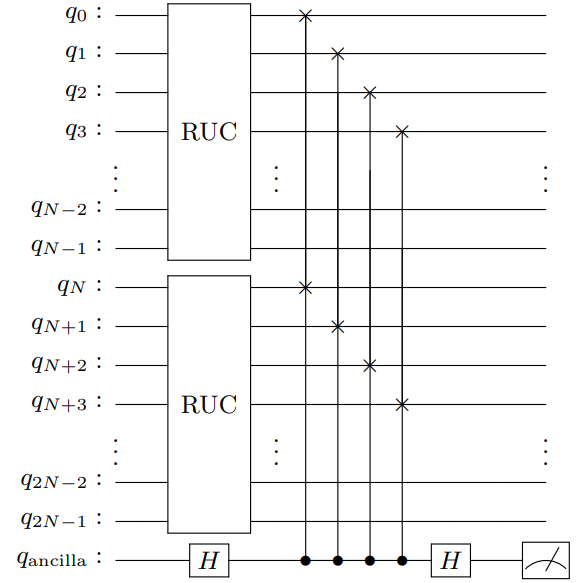

## 4 · Helper functions for building experiment

* `ancilla_hist` collapses outcome bit‑strings to ancilla results.  
* `renyi2` converts ancilla statistics to 2‑Rényi entropy.  
* `build_circuit` runs the qsub → primitive → Qulacs pipeline.

In [ ]:
from collections import Counter, defaultdict
from quri_parts.qsub.resolve import resolve_sub
from quri_parts.qsub.compile import compile_sub
from quri_parts.qsub.primitive import AllBasicSet
from quri_parts.qsub.evaluate import Evaluator
from quri_parts.qsub.eval import QURIPartsEvaluatorHooks

def ancilla_zero_counts(counts: Counter[int]) -> Counter[int]:
    collapsed = defaultdict(int)
    for key, freq in counts.items():
        collapsed[key & 1] += freq    # LSB = ancilla
    return Counter(collapsed)

def renyi2_from_counts(counts: Counter[int], shots: int) -> float:
    p0 = counts[0] / shots
    purity = 2 * p0 - 1
    return -np.log(purity) if purity > 0 else np.inf

def build_qp_circuit(n_sys: int, n_layers: int, n_rad: int):
    resolved = resolve_sub(SwapTest(n_sys, n_layers, n_rad))
    compiled = compile_sub(resolved, AllBasicSet)
    evaluator = Evaluator(QURIPartsEvaluatorHooks())
    return evaluator.run(compiled)


## 5 · Run the experiment

We wrap the sampling loop in **`run_entropy_scan`**.  
The function takes 5 arguments:

* a `sampler` backend,
* system size `n_sys`,
* RUC depth `depth`,
* number of Monte‑Carlo realisations, and
* shots per circuit,

and returns both the `n_rad_list` and a matrix of 2‑Rényi entropies.


In [ ]:
from quri_parts.qulacs.sampler import create_qulacs_general_vector_sampler

def run_entropy_scan(
    sampler,
    n_sys: int,
    depth: int,
    n_real: int,
    n_shots: int,
):
    """Return (n_rad_list, entropy_matrix)."""
    n_rad_list = list(range(1, n_sys))
    entropy_matrix = np.zeros((n_real, len(n_rad_list)))  # realisations × n_rad

    for r in range(n_real):
        for j, n_rad in enumerate(n_rad_list):
            circuit = build_qp_circuit(n_sys, depth, n_rad)
            counts  = sampler(circuit, n_shots)

            # analyse ancilla
            collapsed = ancilla_zero_counts(counts)
            entropy_matrix[r, j] = renyi2_from_counts(collapsed, n_shots)

    return n_rad_list, entropy_matrix

# ---- Run the scan ----------------------------------------------------
N_SYS, DEPTH, N_REAL, N_SHOTS = 8, 8, 10, 10_000
sampler = create_qulacs_general_vector_sampler()

n_rad_list, entropy_matrix = run_entropy_scan(sampler, N_SYS, DEPTH, N_REAL, N_SHOTS)


## 6 · Visualise the average 2‑Rényi entropy

As a result for ideal case, we plot the entropy with respect to the number of radiation qubits in the circuit.

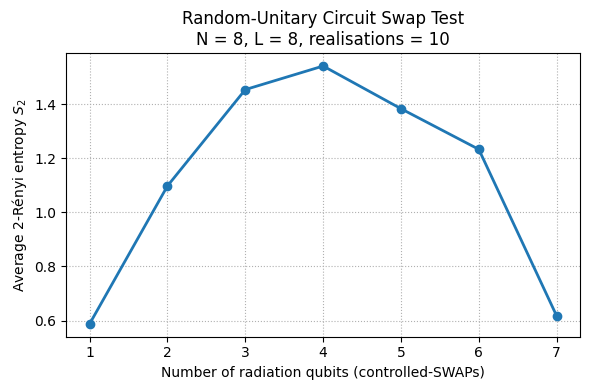

In [ ]:
mean_entropy = entropy_matrix.mean(axis=0)
plt.figure(figsize=(6, 4))
plt.plot(n_rad_list, mean_entropy, "-o", linewidth=2, markersize=6)
plt.xlabel("Number of radiation qubits (controlled-SWAPs)")
plt.ylabel("Average 2-Rényi entropy $S_2$")
plt.title(f"Random-Unitary Circuit Swap Test\n"
          f"N = {N_SYS}, L = {DEPTH}, realisations = {N_REAL}")
plt.grid(True, which="both", linestyle=":")
plt.tight_layout()
plt.show()


## 7 · Hardware noise: resource estimation → **noisy entropy scan**

We now close the loop by *re‑running* **`run_entropy_scan`** under a
hardware‑derived noise model.

Workflow per physical error‑rate `p_phys`  
1. Create a STAR architecture VM instance.  
2. Let `VM.analyze` estimate logical fidelity.  
3. Build **create_qulacs_noisesimulator_general_sampler** from the same noise model.  
4. Call `run_entropy_scan` to obtain the *full* 2‑Rényi entropy curve
   `S₂(n_rad)` under noise.  

Finally we overlay the noisy curves with the noiseless baseline so you can
see how entanglement estimation deteriorates as physical error increases.


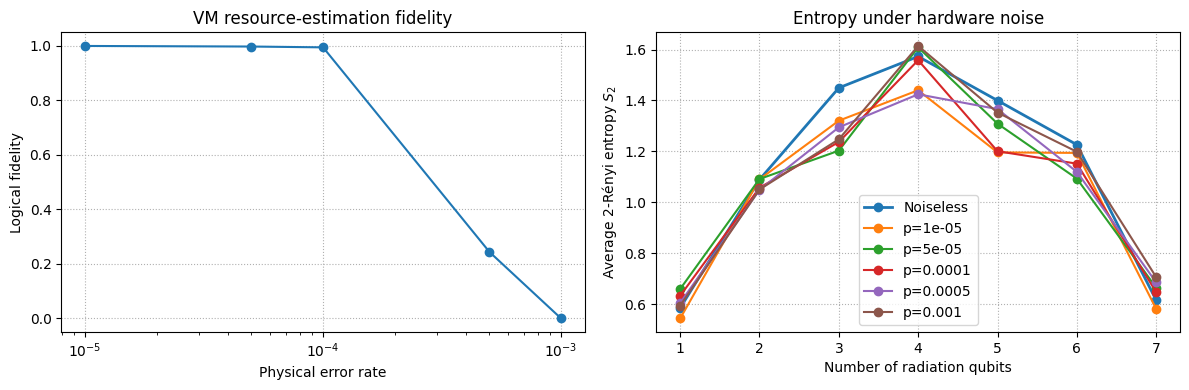

In [ ]:
from quri_parts.backend.devices import star_device
from quri_vm import VM
from quri_parts.backend.units import TimeUnit, TimeValue
from quri_parts.qulacs.sampler import (
    create_qulacs_noisesimulator_general_sampler,
    create_qulacs_density_matrix_general_sampler,
)

# --- Noise sweep parameters -------------------------------------------
noise_levels = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3]

fidelities       = []
entropy_curves   = []   # mean S2 vs n_rad for each noise level

for p_phys in noise_levels:
    # 1) Device + VM analysis
    star_qpu = star_device.generate_device_property(
        qubit_count=100,
        code_distance=9,
        qec_cycle=TimeValue(1, TimeUnit.MICROSECOND),
        physical_error_rate=p_phys,
    )
    star_vm = VM.from_device_prop(star_qpu)
    analysis = star_vm.analyze(build_qp_circuit(N_SYS, DEPTH, N_SYS // 2))
    fidelities.append(analysis.fidelity)

    # 2) Noisy sampler
    noisy_sampler = create_qulacs_noisesimulator_general_sampler(star_qpu.noise_model)

    # 3) Run full entropy scan under noise
    n_rad_list, entropy_mat = run_entropy_scan(
        noisy_sampler, N_SYS, DEPTH, N_REAL, N_SHOTS
    )
    entropy_curves.append(entropy_mat.mean(axis=0))

# --- Plotting ----------------------------------------------------------
# Figure A: logical fidelity vs physical error rate
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].semilogx(noise_levels, fidelities, '-o')
axes[0].set_xlabel('Physical error rate')
axes[0].set_ylabel('Logical fidelity')
axes[0].set_title('VM resource‑estimation fidelity')
axes[0].grid(True, ls=':')

# Figure B: noisy entropy curves + noiseless baseline
# Baseline from earlier Section 6
baseline = entropy_matrix.mean(axis=0)
axes[1].plot(n_rad_list, baseline, '-o', label='Noiseless', linewidth=2)

for curve, p in zip(entropy_curves, noise_levels):
    axes[1].plot(n_rad_list, curve, '-o', label=f'p={p}')

axes[1].set_xlabel('Number of radiation qubits')
axes[1].set_ylabel('Average 2‑Rényi entropy $S_2$')
axes[1].set_title('Entropy under hardware noise')
axes[1].grid(True, ls=':')
axes[1].legend()

plt.tight_layout()
plt.show()

# Example: density‑matrix sampler (not used here, but available)
_ = create_qulacs_density_matrix_general_sampler(star_qpu.noise_model)


## 8. Conclusion

From the result, it suggests that even though we are still not in the era of FTQC, we are still capable to perform simulations that are physically related to some system that cannot be observed directly in practice.
For example, one requires high precision telescope to observe Hawking radiation and that prohibits physicists from testing any theoretical arguments.
However, with some modification, we are capable to partially (without considering back-reaction) check the correctness of Page curve using quantum simulation as demonstrated above.
In fact, the back-reaction should be small for large black hole due to its large inertia, which makes this simulation the leading order check for Page curve.
Overall, since the simulation of black hole at leading order has been checked viable, it will be interesting to further investigate the subleading effect, meaning to find the map from black hole evaporation with back-reaction to quantum circuit.

## References

[1] A. Chowdhury, N. Engelhardt, M. Mezei, A. Rolph, *Page Curves from Random‑Unitary Circuits and the Analytic Second‑Rényi Entropy*, arXiv:2412.15180 (2024).

[2] https://quri-sdk.qunasys.com/docs/tutorials/quri-parts/advanced/qsub/

[3] D. N. Page, *Information in Black Hole Radiation*, **Phys. Rev. Lett.** 71, 3743 (1993).

